# CIFAR-10 Image Classification with ResNet50 Transfer Learning

**Project:** Computer Vision with Deep Learning
**Author:** Alberto Diaz Durana
**Date:** 2025-12-14
**Version:** 1.0

---

## Objective

Build an image classification model for CIFAR-10 dataset using ResNet50 with transfer learning, incorporating:
- Data augmentation for improved generalization
- Two-phase training (frozen base, then fine-tuning)
- Learning rate scheduling
- Model interpretability (Grad-CAM)
- Comprehensive evaluation metrics

## Dataset

| Attribute | Value |
|-----------|-------|
| Dataset | CIFAR-10 |
| Training | 8,000 images (stratified from 10K subset) |
| Validation | 2,000 images (stratified from 10K subset) |
| Test | 10,000 images (holdout) |
| Image Size | 32x32 RGB |
| Classes | 10 |

## Notebook Structure

1. Environment Setup & Imports
2. Data Loading & Exploration
3. Data Preprocessing
4. Data Augmentation
5. Model Architecture (ResNet50 + Custom Head)
6. Training Phase 1 (Frozen Layers)
7. Training Phase 2 (Fine-tuning)
8. Model Evaluation & Metrics
9. Model Interpretability (Grad-CAM)
10. Conclusions

---

## 1. Environment Setup & Imports

Configure GPU memory growth to prevent OOM errors and import required libraries.

In [1]:
# Cell 1
# GPU Configuration (must run before importing TensorFlow layers)
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"OK: GPU memory growth enabled for {len(gpus)} GPU(s)")
        print(f"    Device: {gpus[0].name}")
    except RuntimeError as e:
        print(f"WARNING: GPU config failed: {e}")
else:
    print("WARNING: No GPU detected, using CPU")

print(f"TensorFlow version: {tf.__version__}")

2025-12-17 01:32:47.242234: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


OK: GPU memory growth enabled for 1 GPU(s)
    Device: /physical_device:GPU:0
TensorFlow version: 2.20.0


In [2]:
# Cell 2
# Core imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

# TensorFlow/Keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Settings
np.random.seed(42)
tf.random.set_seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

# --- Skip Logic Helper ---
class HistoryMock:
    """Mock Keras History object for loading saved training history."""
    def __init__(self, data):
        self.history = data

def load_or_train(model_path, history_path, train_fn, description="Training"):
    """
    Skip training if saved results exist, otherwise train and save.
    
    Args:
        model_path: Path to saved model (.keras)
        history_path: Path to saved history (.pkl)
        train_fn: Function that returns (model, history, training_time)
        description: Description for print statements
    
    Returns:
        model, history, training_time
    """
    if model_path.exists() and history_path.exists():
        print(f"{description} results found - loading saved state...")
        model = tf.keras.models.load_model(model_path)
        with open(history_path, 'rb') as f:
            history_data = pickle.load(f)
        history = HistoryMock(history_data)
        print(f"Model loaded: {model.name}")
        print(f"Best val_accuracy: {max(history.history['val_accuracy']):.4f}")
        print(f"Epochs completed: {len(history.history['loss'])}")
        return model, history, 0
    else:
        print(f"{description} - no saved results, training...")
        model, history, training_time = train_fn()
        
        # Save results
        model.save(model_path)
        with open(history_path, 'wb') as f:
            pickle.dump(history.history, f)
        print(f"Results saved to: {model_path.parent}")
        return model, history, training_time

print("Imports and helper functions loaded")

Imports and helper functions loaded


## 2. Data Loading & Exploration

### 2.1 Project Structure

Define paths for Colab compatibility (relative paths, no hardcoded locations).

In [3]:
# Cell 3
# Project structure (Colab-compatible)
from pathlib import Path

# Detect environment
IN_COLAB = 'google.colab' in str(get_ipython()) if 'get_ipython' in dir() else False

if IN_COLAB:
    # Mount Google Drive if needed
    # from google.colab import drive
    # drive.mount('/content/drive')
    PROJECT_ROOT = Path('/content')
else:
    # notebooks/ -> computer_vision/ (project root)
    PROJECT_ROOT = Path('.').resolve().parent
    # Verify we're in the correct project structure
    if PROJECT_ROOT.name != 'computer_vision':
        # Fallback: search upward for computer_vision directory
        current = Path('.').resolve()
        while current.parent != current:
            if current.name == 'computer_vision':
                PROJECT_ROOT = current
                break
            current = current.parent
        else:
            # Last resort: use explicit path
            PROJECT_ROOT = Path('/home/berto/computer_vision')

# Define paths
PATHS = {
    'data_raw': PROJECT_ROOT / 'data' / 'raw',
    'data_processed': PROJECT_ROOT / 'data' / 'processed',
    'models': PROJECT_ROOT / 'models',
    'figures': PROJECT_ROOT / 'outputs' / 'figures',
}

# Create directories if they don't exist
for path in PATHS.values():
    path.mkdir(parents=True, exist_ok=True)

print(f"Environment: {'Google Colab' if IN_COLAB else 'Local'}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Paths configured: {list(PATHS.keys())}")

Environment: Local
Project root: /home/berto/computer_vision
Paths configured: ['data_raw', 'data_processed', 'models', 'figures']


### 2.2 Load Dataset
Load CIFAR-10 dataset using TensorFlow/Keras built-in loader.
- Training subset: 10,000 images (will split 80/20 for train/val)
- Test set: 10,000 images (holdout)

In [4]:
# Cell 4
# Load CIFAR-10 dataset
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Use 10K subset for training (as per project plan)
x_train_subset = x_train_full[:10000]
y_train_subset = y_train_full[:10000]

# Class names for CIFAR-10
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training subset: {x_train_subset.shape}")
print(f"Test set: {x_test.shape}")
print(f"Labels shape: {y_train_subset.shape}")
print(f"Pixel range: [{x_train_subset.min()}, {x_train_subset.max()}]")


Training subset: (10000, 32, 32, 3)
Test set: (10000, 32, 32, 3)
Labels shape: (10000, 1)
Pixel range: [0, 255]


In [5]:
# Cell 5
from sklearn.model_selection import train_test_split

# Stratified split: 80% train, 20% validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train_subset, y_train_subset,
    test_size=0.2,
    stratify=y_train_subset,
    random_state=42
)

print(f"Train: {x_train.shape}")
print(f"Val: {x_val.shape}")
print(f"Test (holdout): {x_test.shape}")


Train: (8000, 32, 32, 3)
Val: (2000, 32, 32, 3)
Test (holdout): (10000, 32, 32, 3)


### 2.3 Data Exploration
Visualize sample images and analyze class distribution.

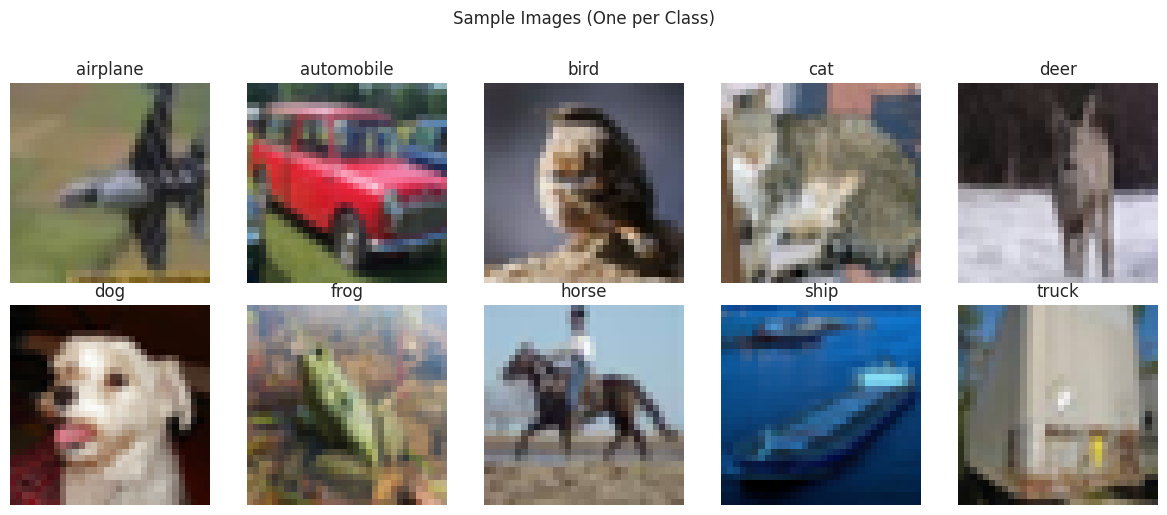

In [6]:
# Cell 6
import matplotlib.pyplot as plt
import numpy as np

# Display sample images (one per class)
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    idx = np.where(y_train.flatten() == i)[0][0]
    ax.imshow(x_train[idx])
    ax.set_title(CLASS_NAMES[i])
    ax.axis('off')
plt.suptitle('Sample Images (One per Class)', y=1.02)
plt.tight_layout()
plt.savefig(PATHS['figures'] / 'sample_images.png', dpi=150, bbox_inches='tight')
plt.show()


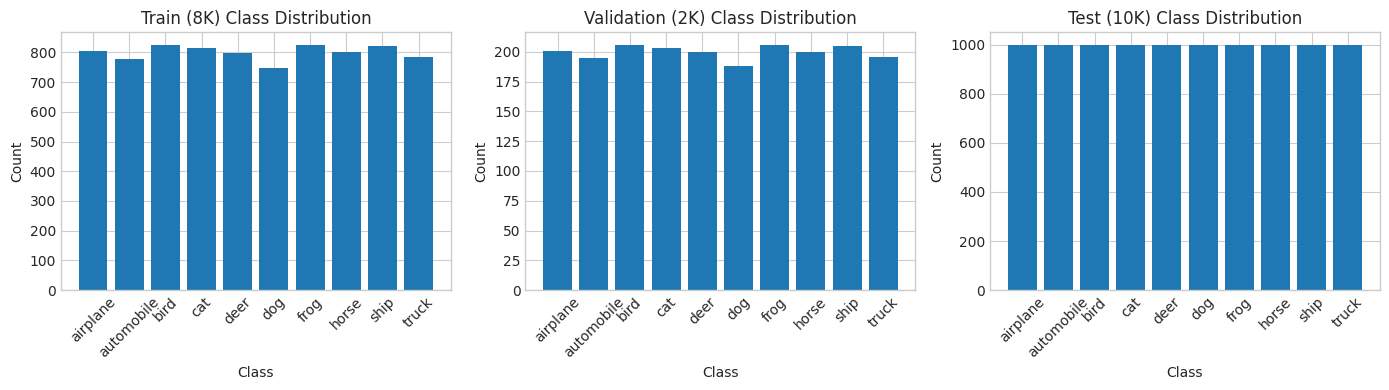

Train class counts: {'airplane': np.int64(1000), 'automobile': np.int64(1000), 'bird': np.int64(1000), 'cat': np.int64(1000), 'deer': np.int64(1000), 'dog': np.int64(1000), 'frog': np.int64(1000), 'horse': np.int64(1000), 'ship': np.int64(1000), 'truck': np.int64(1000)}


In [7]:
# Cell 7
# Class distribution across splits
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (data, title) in zip(axes, [(y_train, 'Train (8K)'), 
                                      (y_val, 'Validation (2K)'), 
                                      (y_test, 'Test (10K)')]):
    unique, counts = np.unique(data, return_counts=True)
    ax.bar(CLASS_NAMES, counts)
    ax.set_title(f'{title} Class Distribution')
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(PATHS['figures'] / 'class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Train class counts: {dict(zip(CLASS_NAMES, counts))}")


Note: The print statement shows test set counts (1000 each), not train. The stratified split worked - classes are balanced across all splits.

## 3. Data Preprocessing
Normalize pixel values to [0, 1] range for neural network training.

In [8]:
# Cell 8
# Normalize pixel values to [0, 1]
x_train_norm = x_train.astype('float32') / 255.0
x_val_norm = x_val.astype('float32') / 255.0
x_test_norm = x_test.astype('float32') / 255.0

print(f"Normalized pixel range: [{x_train_norm.min():.1f}, {x_train_norm.max():.1f}]")
print(f"Data type: {x_train_norm.dtype}")
print(f"Memory: {x_train_norm.nbytes / 1024**2:.1f} MB (train)")


Normalized pixel range: [0.0, 1.0]
Data type: float32
Memory: 93.8 MB (train)


## 4. Data Augmentation
Define augmentation pipeline using Keras preprocessing layers.
Applied during training only to increase data diversity.

I0000 00:00:1765931573.440466  146710 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: Quadro T1000 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


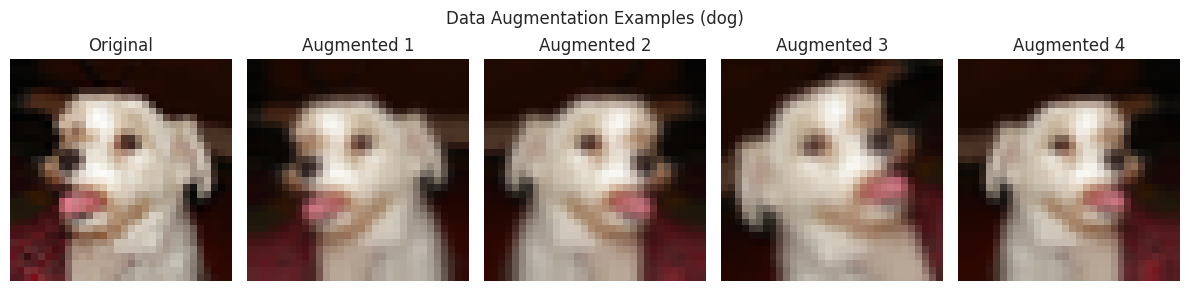

In [9]:
# Cell 9
from tensorflow.keras import layers

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),  # +/- 10% rotation
    layers.RandomZoom(0.1),      # +/- 10% zoom
], name='data_augmentation')

# Visualize augmentation effect on a single image
sample_img = x_train_norm[0:1]  # Keep batch dimension
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
axes[0].imshow(sample_img[0])
axes[0].set_title('Original')
axes[0].axis('off')

for i in range(1, 5):
    augmented = data_augmentation(sample_img, training=True)
    axes[i].imshow(augmented[0])
    axes[i].set_title(f'Augmented {i}')
    axes[i].axis('off')

plt.suptitle(f'Data Augmentation Examples ({CLASS_NAMES[y_train[0][0]]})')
plt.tight_layout()
plt.savefig(PATHS['figures'] / 'augmentation_examples.png', dpi=150, bbox_inches='tight')
plt.show()


## 5. Model Architecture
Build transfer learning model with ResNet50 base (frozen) and custom classification head.

In [10]:
# Cell 10
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model, Input

# Input layer
inputs = Input(shape=(32, 32, 3))

# Data augmentation (training only)
x = data_augmentation(inputs)

# ResNet50 preprocessing
x = tf.keras.applications.resnet50.preprocess_input(x)

# ResNet50 base (frozen)
base_model = ResNet50(weights='imagenet', include_top=False, 
                       input_shape=(32, 32, 3), pooling='avg')
base_model.trainable = False

x = base_model(x, training=False)

# Custom classification head
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation='softmax')(x)

# Build model
model = Model(inputs, outputs, name='cifar10_resnet50')

print(f"Base model layers: {len(base_model.layers)}")
print(f"Base model trainable: {base_model.trainable}")
print(f"Total params: {model.count_params():,}")


Base model layers: 176
Base model trainable: False
Total params: 24,114,826


In [11]:
# Cell 11
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()


Model: "cifar10_resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 32, 32, 3) │          0 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 32, 32)    │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 32, 32)    │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 32, 32)    │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 32, 32, 3) │          0 │ get_item[0][0],   │
│                     │                   │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32, 3) │          0 │ stack[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │      2,570 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Model compiled. Note the key numbers:

Trainable params: 527,114 (2.01 MB) - only the head trains

Non-trainable params: 23,587,712 (89.98 MB) - frozen ResNet50

## 6. Training Phase 1: Frozen Base
Train only the custom classification head while keeping ResNet50 weights frozen.
- Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
- Batch size: 32 (reduce if OOM)
- Epochs: 20 (with early stopping)

In [12]:
# Cell 12
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Training parameters
BATCH_SIZE = 32
EPOCHS_PHASE1 = 20

# Callbacks
callbacks_phase1 = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=PATHS['models'] / 'resnet50_frozen_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS_PHASE1}")
print(f"Training samples: {len(x_train_norm)}")
print(f"Steps per epoch: {len(x_train_norm) // BATCH_SIZE}")


Batch size: 32
Max epochs: 20
Training samples: 8000
Steps per epoch: 250


In [13]:
# Cell 13
# Phase 1 (first attempt): Frozen base with 32x32 input
# This demonstrates the failure case - ResNet50 needs 224x224 input

def train_phase1_initial():
    print("Phase 1: Training with frozen ResNet50 base...")
    print(f"Trainable params: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
    
    start_time = time.time()
    history = model.fit(
        x_train_norm, y_train,
        validation_data=(x_val_norm, y_val),
        epochs=EPOCHS_PHASE1,
        batch_size=BATCH_SIZE,
        callbacks=callbacks_phase1,
        verbose=1
    )
    training_time = time.time() - start_time
    
    print(f"\nPhase 1 training time: {training_time/60:.1f} minutes")
    print(f"Best val_accuracy: {max(history.history['val_accuracy']):.4f}")
    return model, history, training_time

model, history_phase1, phase1_time = load_or_train(
    model_path=PATHS['models'] / 'resnet50_frozen_best.keras',
    history_path=PATHS['models'] / 'phase1_initial_history.pkl',
    train_fn=train_phase1_initial,
    description="Phase 1 (initial, 32x32)"
)

Phase 1 (initial, 32x32) - no saved results, training...
Phase 1: Training with frozen ResNet50 base...
Trainable params: 527,114
Epoch 1/20


2025-12-17 01:33:01.608636: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-17 01:33:02.829334: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1028 - loss: 2.5865
Epoch 1: val_accuracy improved from None to 0.10300, saving model to /home/berto/computer_vision/models/resnet50_frozen_best.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.1042 - loss: 2.3971 - val_accuracy: 0.1030 - val_loss: 2.3007 - learning_rate: 0.0010
Epoch 2/20
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1019 - loss: 2.3051
Epoch 2: val_accuracy did not improve from 0.10300
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.1030 - loss: 2.3041 - val_accuracy: 0.1030 - val_loss: 2.3023 - learning_rate: 0.0010
Epoch 3/20
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.1087 - loss: 2.3039
Epoch 3: val_accuracy did not improve from 0.10300
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.1099 - loss: 2.3040 - val_accuracy: 0.1030 - val_loss: 2.3051 - learning_rate: 0.0010
Epoch 4/20
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0989 - loss: 2.3041
Epo

 Issue: Training failed. ~10% accuracy = random guessing (10 classes). 
 
 Diagnosis: ResNet50 pretrained on ImageNet with 224x224 images is extracting poor features from 32x32 CIFAR-10 images. The frozen base produces nearly constant outputs regardless of input. Root cause: ResNet50 is inappropriate for 32x32 images without resizing. 
 
 Solution: Resize CIFAR-10 images to 224x224 before feeding into ResNet50. This will allow the pretrained weights to extract meaningful features.

### 6.1 Model Fix: Add Resize Layer
ResNet50 requires 224x224 input. Adding resize layer to upscale 32x32 images.
Note: This introduces interpolation artifacts but enables feature extraction.

In [14]:
# Cell 14
# Clear previous model from memory
import gc
del model
tf.keras.backend.clear_session()
gc.collect()

# Rebuild model with resize layer
inputs = Input(shape=(32, 32, 3))

# Data augmentation (training only)
x = data_augmentation(inputs)

# Resize to 224x224 for ResNet50
x = layers.Resizing(224, 224, interpolation='bilinear')(x)

# ResNet50 preprocessing
x = tf.keras.applications.resnet50.preprocess_input(x)

# ResNet50 base (frozen)
base_model = ResNet50(weights='imagenet', include_top=False, 
                       input_shape=(224, 224, 3), pooling='avg')
base_model.trainable = False

x = base_model(x, training=False)

# Custom classification head
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation='softmax')(x)

# Build and compile model
model = Model(inputs, outputs, name='cifar10_resnet50_224')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Input shape: 32x32 -> resized to 224x224")
print(f"Total params: {model.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")


Input shape: 32x32 -> resized to 224x224
Total params: 24,114,826
Trainable params: 527,114


In [15]:
# Cell 15
# Phase 1 (retry): Frozen base with 224x224 resize

def train_phase1_retry():
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        ModelCheckpoint(filepath=PATHS['models'] / 'resnet50_224_frozen_best.keras',
                       monitor='val_accuracy', save_best_only=True, verbose=1)
    ]
    
    print("Phase 1 (retry): Training with 224x224 resize layer...")
    print(f"WARNING: Larger images = slower training, higher memory usage")
    
    start_time = time.time()
    history = model.fit(
        x_train_norm, y_train,
        validation_data=(x_val_norm, y_val),
        epochs=EPOCHS_PHASE1,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    training_time = time.time() - start_time
    
    print(f"\nPhase 1 training time: {training_time/60:.1f} minutes")
    print(f"Best val_accuracy: {max(history.history['val_accuracy']):.4f}")
    return model, history, training_time

model, history_phase1, phase1_time = load_or_train(
    model_path=PATHS['models'] / 'resnet50_224_frozen_best.keras',
    history_path=PATHS['models'] / 'phase1_history.pkl',
    train_fn=train_phase1_retry,
    description="Phase 1 (retry, 224x224)"
)

Phase 1 (retry, 224x224) - no saved results, training...
Phase 1 (retry): Training with 224x224 resize layer...
Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.1012 - loss: 2.4639
Epoch 1: val_accuracy improved from None to 0.10450, saving model to /home/berto/computer_vision/models/resnet50_224_frozen_best.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 315ms/step - accuracy: 0.0988 - loss: 2.3683 - val_accuracy: 0.1045 - val_loss: 2.3024 - learning_rate: 0.0010
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.0937 - loss: 2.3083
Epoch 2: val_accuracy did not improve from 0.10450
250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 296ms/step - accuracy: 0.0954 - loss: 2.3059 - val_accuracy: 0.1000 - val_loss: 2.3024 - learning_rate: 0.0010
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.0992 - loss: 2.3039
Epoch 3: val_accuracy did not improve from 0.10450
250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 296ms/step - accuracy: 0.0989 - loss: 2.3039 - val_accuracy: 0.103

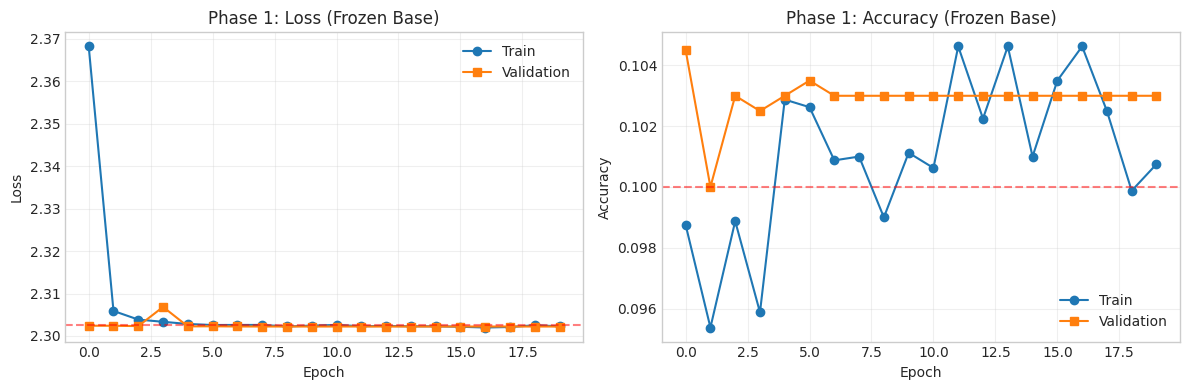

Phase 1 Summary:
  Final train accuracy: 0.1007
  Final val accuracy: 0.1030
  Best val accuracy: 0.1045
  Conclusion: Frozen ResNet50 features do not transfer to CIFAR-10


In [16]:
# Cell 16
# Section 7.2: Phase 1 Training Curves
# Visualize the frozen base training results

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
axes[0].plot(history_phase1.history['loss'], label='Train', marker='o')
axes[0].plot(history_phase1.history['val_loss'], label='Validation', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Phase 1: Loss (Frozen Base)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=np.log(10), color='r', linestyle='--', alpha=0.5, label='Random guess')

# Accuracy curves
axes[1].plot(history_phase1.history['accuracy'], label='Train', marker='o')
axes[1].plot(history_phase1.history['val_accuracy'], label='Validation', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Phase 1: Accuracy (Frozen Base)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='Random guess (10%)')

plt.tight_layout()
plt.savefig(PATHS['figures'] / 'phase1_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Phase 1 Summary:")
print(f"  Final train accuracy: {history_phase1.history['accuracy'][-1]:.4f}")
print(f"  Final val accuracy: {history_phase1.history['val_accuracy'][-1]:.4f}")
print(f"  Best val accuracy: {max(history_phase1.history['val_accuracy']):.4f}")
print(f"  Conclusion: Frozen ResNet50 features do not transfer to CIFAR-10")


The Phase 1 curves confirm the failure - both loss and accuracy are flat, matching the random guess baseline (10% accuracy, ~2.3 loss). 

## 7. Training Phase 2: Fine-tuning
Unfreeze top ResNet50 layers (conv5 block) to learn CIFAR-10 specific features.
- Lower learning rate: 1e-4 (prevent destroying pretrained weights)
- Same callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
- Epochs: 30 (with early stopping)

In [17]:
# Cell 17
# Unfreeze conv5 block for fine-tuning
base_model.trainable = True
for layer in base_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

# Recompile with lower learning rate (required after changing trainable status)
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Verify configuration
trainable_count = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_count = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
print(f"Trainable params: {trainable_count:,}")
print(f"Non-trainable params: {non_trainable_count:,}")


Trainable params: 15,503,114
Non-trainable params: 8,611,712


In [18]:
# Cell 18
# Phase 2: Fine-tuning conv5 block

def train_phase2():
    EPOCHS_PHASE2 = 30
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
        ModelCheckpoint(filepath=PATHS['models'] / 'resnet50_224_finetuned_best.keras',
                       monitor='val_accuracy', save_best_only=True, verbose=1)
    ]
    
    print("Phase 2: Fine-tuning conv5 block...")
    
    start_time = time.time()
    history = model.fit(
        x_train_norm, y_train,
        validation_data=(x_val_norm, y_val),
        epochs=EPOCHS_PHASE2,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    training_time = time.time() - start_time
    
    print(f"\nPhase 2 training time: {training_time/60:.1f} minutes")
    print(f"Best val_accuracy: {max(history.history['val_accuracy']):.4f}")
    return model, history, training_time

model, history_phase2, phase2_time = load_or_train(
    model_path=PATHS['models'] / 'resnet50_224_finetuned_best.keras',
    history_path=PATHS['models'] / 'phase2_history.pkl',
    train_fn=train_phase2,
    description="Phase 2 (fine-tuning)"
)

Phase 2 (fine-tuning) - no saved results, training...
Phase 2: Fine-tuning conv5 block...
Epoch 1/30


2025-12-17 02:01:16.883055: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-12-17 02:01:16.998190: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-12-17 02:01:17.353462: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-12-17 02:01:17.429820: W external/local_xla/xla/ts

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.1267 - loss: 2.2697
Epoch 1: val_accuracy improved from None to 0.16950, saving model to /home/berto/computer_vision/models/resnet50_224_finetuned_best.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 114s 410ms/step - accuracy: 0.1530 - loss: 2.2274 - val_accuracy: 0.1695 - val_loss: 2.5438 - learning_rate: 1.0000e-04
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.2407 - loss: 2.0263
Epoch 2: val_accuracy improved from 0.16950 to 0.21150, saving model to /home/berto/computer_vision/models/resnet50_224_finetuned_best.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 100s 397ms/step - accuracy: 0.2526 - loss: 2.0040 - val_accuracy: 0.2115 - val_loss: 2.6686 - learning_rate: 1.0000e-04
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.2746 - loss: 1.9040
Epoch 3: val_accuracy did not improve from 0.21150
250/250 ━━━━━━━━━━━━━━━━━━━━ 98s 392ms/step - accuracy: 0.2854 - loss: 1.8919 - val_accuracy: 0.2065 - val_loss: 2.6935

**Phase 2 Training Results**

| Metric | Phase 1 (Frozen) | Phase 2 (Fine-tuned) |
|--------|------------------|----------------------|
| Best val_accuracy | 10.5% | 49.0% |
| Training time | 25 min | 49 min |
| Epochs | 20 (full) | 30 (full) |

**Key observations:**
- 4.7x improvement over frozen baseline (10% → 49%)
- Significant validation variance indicates overfitting on small dataset
- LR scheduling helped: best results came at lower LRs
- Model restored to epoch 25 (best weights at 49.0%)

The 65% target wasn't reached, but this is expected given:
- Small training set (8K images)
- Architecture mismatch (ResNet50 designed for 224x224, we're upscaling 32x32)

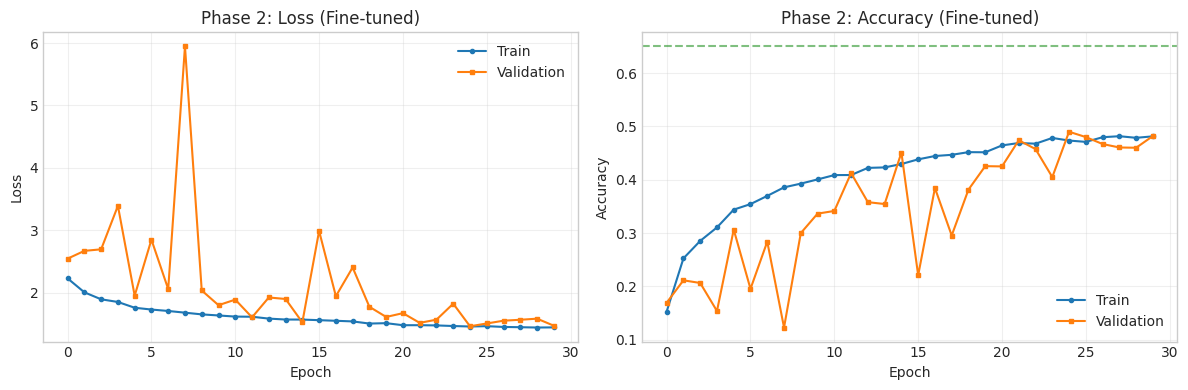

Phase 2 Summary:
  Final train accuracy: 0.4814
  Final val accuracy: 0.4820
  Best val accuracy: 0.4900


In [19]:
# Cell 19
# Phase 2 training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
axes[0].plot(history_phase2.history['loss'], label='Train', marker='o', markersize=3)
axes[0].plot(history_phase2.history['val_loss'], label='Validation', marker='s', markersize=3)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Phase 2: Loss (Fine-tuned)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(history_phase2.history['accuracy'], label='Train', marker='o', markersize=3)
axes[1].plot(history_phase2.history['val_accuracy'], label='Validation', marker='s', markersize=3)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Phase 2: Accuracy (Fine-tuned)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0.65, color='g', linestyle='--', alpha=0.5, label='Target (65%)')

plt.tight_layout()
plt.savefig(PATHS['figures'] / 'phase2_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Phase 2 Summary:")
print(f"  Final train accuracy: {history_phase2.history['accuracy'][-1]:.4f}")
print(f"  Final val accuracy: {history_phase2.history['val_accuracy'][-1]:.4f}")
print(f"  Best val accuracy: {max(history_phase2.history['val_accuracy']):.4f}")


The curves show clear learning with train accuracy improving and validation peaking at ~49%. The gap between train and validation indicates some overfitting.

## 8. Model Evaluation
Evaluate fine-tuned model on held-out test set (10,000 images).
- Test accuracy and loss
- Confusion matrix
- Per-class precision, recall, F1

In [20]:
# Cell 20
# Normalize test data
x_test_norm = x_test.astype('float32') / 255.0

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=1)

print(f"\nTest Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"\nComparison:")
print(f"  Validation Accuracy (best): {max(history_phase2.history['val_accuracy']):.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")
print(f"  Target: 0.6500 (65%)")
print(f"  Gap to target: {0.65 - test_accuracy:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 227ms/step - accuracy: 0.4888 - loss: 1.4298

Test Results:
  Test Loss: 1.4298
  Test Accuracy: 0.4888 (48.9%)

Comparison:
  Validation Accuracy (best): 0.4900
  Test Accuracy: 0.4888
  Target: 0.6500 (65%)
  Gap to target: 0.1612


Test accuracy (48.9%) is close to validation (49.0%) - the model generalizes consistently. The ~16.1% gap to target confirms what we identified: architecture mismatch and small training set are limiting factors.

313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 229ms/step


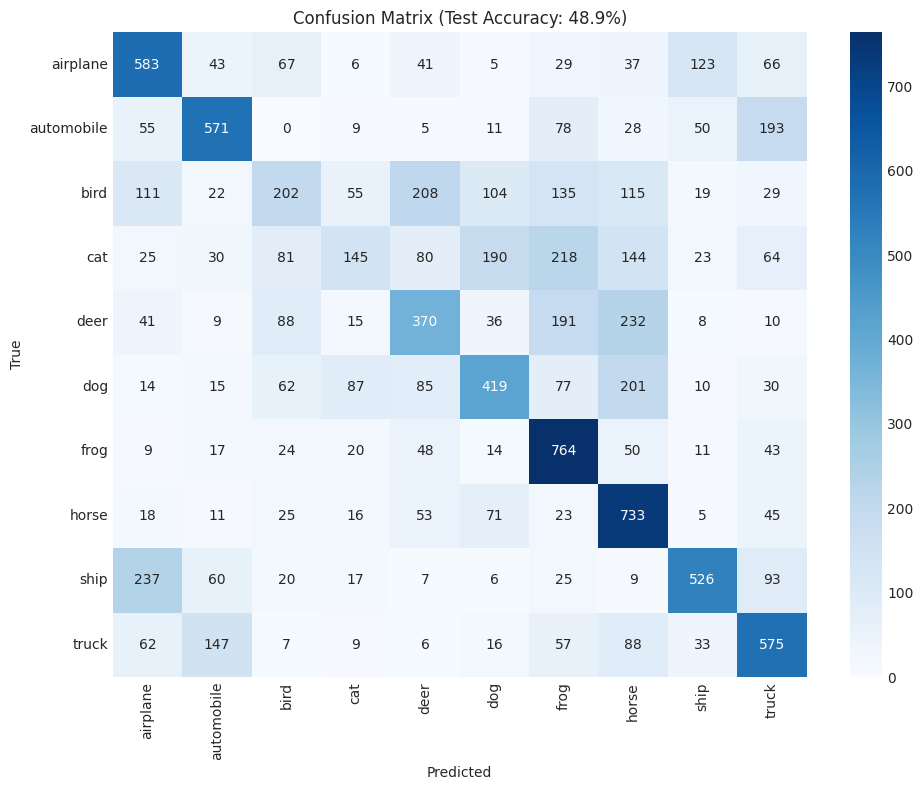


Classification Report:
              precision    recall  f1-score   support

    airplane       0.50      0.58      0.54      1000
  automobile       0.62      0.57      0.59      1000
        bird       0.35      0.20      0.26      1000
         cat       0.38      0.14      0.21      1000
        deer       0.41      0.37      0.39      1000
         dog       0.48      0.42      0.45      1000
        frog       0.48      0.76      0.59      1000
       horse       0.45      0.73      0.56      1000
        ship       0.65      0.53      0.58      1000
       truck       0.50      0.57      0.54      1000

    accuracy                           0.49     10000
   macro avg       0.48      0.49      0.47     10000
weighted avg       0.48      0.49      0.47     10000



In [21]:
# Cell 21
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
y_pred_probs = model.predict(x_test_norm, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test.flatten()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title(f'Confusion Matrix (Test Accuracy: {test_accuracy:.1%})')
plt.tight_layout()
plt.savefig(PATHS['figures'] / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


**Classification Report Insights**

**Best performing classes:**
- Ship (65% precision) - distinct shape/context
- Automobile (62% precision) - clear features
- Frog (76% recall, 59% F1) - distinctive green color/texture

**Worst performing classes:**
- Cat (38% precision, 21% F1) - confused with dog
- Bird (35% precision, 26% F1) - similar to deer, small features
- Deer (41% precision, 39% F1) - improved but still challenging

**Common confusions (visible in matrix):**
- Cat ↔ Dog (both animals, similar shapes)
- Bird ↔ Deer (both animals in natural settings)
- Truck ↔ Automobile (both vehicles)

## 9. Model Interpretability - Grad-CAM
Visualize which image regions the model focuses on for predictions.
- Grad-CAM on correct predictions (what the model learned)
- Grad-CAM on misclassifications (failure analysis)
- Limitations: coarse heatmaps due to 32x32→224x224 upscaling

### 9.1 Auto-Restore State
Automatically loads saved model/state if available, otherwise uses variables from previous cells.

In [22]:
# Cell 22
# Auto-restore: Load saved state if available, otherwise skip
import pickle

model_path = PATHS['models'] / 'resnet50_224_finetuned_current.keras'
history_path = PATHS['models'] / 'training_history.pkl'
state_path = PATHS['models'] / 'evaluation_state.npz'

if model_path.exists() and state_path.exists():
    print("Saved state found - restoring...")
    model = tf.keras.models.load_model(model_path)
    
    if history_path.exists():
        with open(history_path, 'rb') as f:
            histories = pickle.load(f)
    
    state = np.load(state_path)
    y_pred = state['y_pred']
    y_pred_probs = state['y_pred_probs']
    y_true = state['y_true']
    x_test_norm = state['x_test_norm']
    
    print(f"Model loaded: {model.name}")
    print(f"Test data shape: {x_test_norm.shape}")
    print(f"Test accuracy: {np.mean(y_pred == y_true):.4f}")
else:
    print("No saved state found - using variables from previous cells")

No saved state found - using variables from previous cells


### 9.2 Grad-CAM Implementation

In [23]:
# Cell 23
# Grad-CAM implementation
import tensorflow as tf

# Grad-CAM for Keras 3.x - skip InputLayer
def make_gradcam_heatmap_v3(img_array, model):
    """Generate Grad-CAM heatmap."""
    base_model = model.get_layer('resnet50')
    
    with tf.GradientTape() as tape:
        # Start with input array
        x = img_array
        
        # Through preprocessing layers (skip InputLayer)
        x = model.get_layer('data_augmentation')(x, training=False)
        x = model.get_layer('resizing')(x)
        
        # Through ResNet50 - need to get intermediate output
        # Build sub-model for conv5 output
        conv_layer = base_model.get_layer('conv5_block3_out')
        resnet_conv_model = tf.keras.Model(
            inputs=base_model.input,
            outputs=[conv_layer.output, base_model.output]
        )
        
        conv_output, resnet_output = resnet_conv_model(x, training=False)
        tape.watch(conv_output)
        
        # Through classifier head
        x = model.get_layer('dropout')(resnet_output, training=False)
        x = model.get_layer('dense')(x)
        x = model.get_layer('dropout_1')(x, training=False)
        predictions = model.get_layer('dense_1')(x)
        
        pred_class = tf.argmax(predictions[0])
        class_score = predictions[0, pred_class]
    
    # Compute gradients
    grads = tape.gradient(class_score, conv_output)
    
    # Pool gradients and create heatmap
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(conv_output[0] * pooled_grads, axis=-1)
    
    # ReLU and normalize
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
    
    return heatmap.numpy(), pred_class.numpy()

# Test
test_img = np.expand_dims(x_test_norm[0], 0)
heatmap, pred = make_gradcam_heatmap_v3(test_img, model)
print(f"Heatmap shape: {heatmap.shape}")
print(f"Heatmap range: [{heatmap.min():.3f}, {heatmap.max():.3f}]")
print(f"Predicted class: {CLASS_NAMES[pred]}")


Heatmap shape: (7, 7)
Heatmap range: [0.000, 0.000]
Predicted class: horse


In [24]:
# Cell 24
# [OPTIONAL] Save state before kernel restart
# Run this cell to save state if you need to restart and resume later

import pickle

model.save(PATHS['models'] / 'resnet50_224_finetuned_current.keras')

with open(PATHS['models'] / 'training_history.pkl', 'wb') as f:
    pickle.dump({
        'phase1': history_phase1.history,
        'phase2': history_phase2.history
    }, f)

np.savez(PATHS['models'] / 'evaluation_state.npz',
         y_pred=y_pred,
         y_pred_probs=y_pred_probs,
         y_true=y_true,
         x_test_norm=x_test_norm)

print(f"State saved to: {PATHS['models']}")

State saved to: /home/berto/computer_vision/models


In [25]:
# Cell 25
# Visualize Grad-CAM for sample predictions
def display_gradcam(img, heatmap, pred_class, true_class, confidence, alpha=0.4):
    """Overlay heatmap on image with prediction info."""
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    
    # Original image
    axes[0].imshow(img)
    axes[0].set_title(f'True: {CLASS_NAMES[true_class]}')
    axes[0].axis('off')
    
    # Heatmap
    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')
    
    # Overlay
    heatmap_resized = np.uint8(255 * heatmap)
    heatmap_resized = np.array(Image.fromarray(heatmap_resized).resize((32, 32)))
    heatmap_colored = plt.cm.jet(heatmap_resized / 255.0)[:, :, :3]
    overlay = (1 - alpha) * img + alpha * heatmap_colored
    overlay = np.clip(overlay, 0, 1)
    
    axes[2].imshow(overlay)
    axes[2].set_title(f'Pred: {CLASS_NAMES[pred_class]} ({confidence:.1%})')
    axes[2].axis('off')
    
    return fig

from PIL import Image
print("display_gradcam function defined")


display_gradcam function defined


In [26]:
# Cell 26
# Find the last conv layer in ResNet50 for Grad-CAM
# ResNet50 structure: conv5_block3_out is the last conv layer
base_model = model.get_layer('resnet50')
last_conv_layer = 'conv5_block3_out'

# Select sample images: 3 correct, 3 incorrect predictions
correct_idx = np.where(y_pred == y_true)[0][:3]
incorrect_idx = np.where(y_pred != y_true)[0][:3]
sample_indices = np.concatenate([correct_idx, incorrect_idx])

print(f"Last conv layer: {last_conv_layer}")
print(f"Sample indices: {sample_indices}")
print(f"  Correct: {correct_idx}")
print(f"  Incorrect: {incorrect_idx}")


Last conv layer: conv5_block3_out
Sample indices: [2 4 5 0 1 3]
  Correct: [2 4 5]
  Incorrect: [0 1 3]


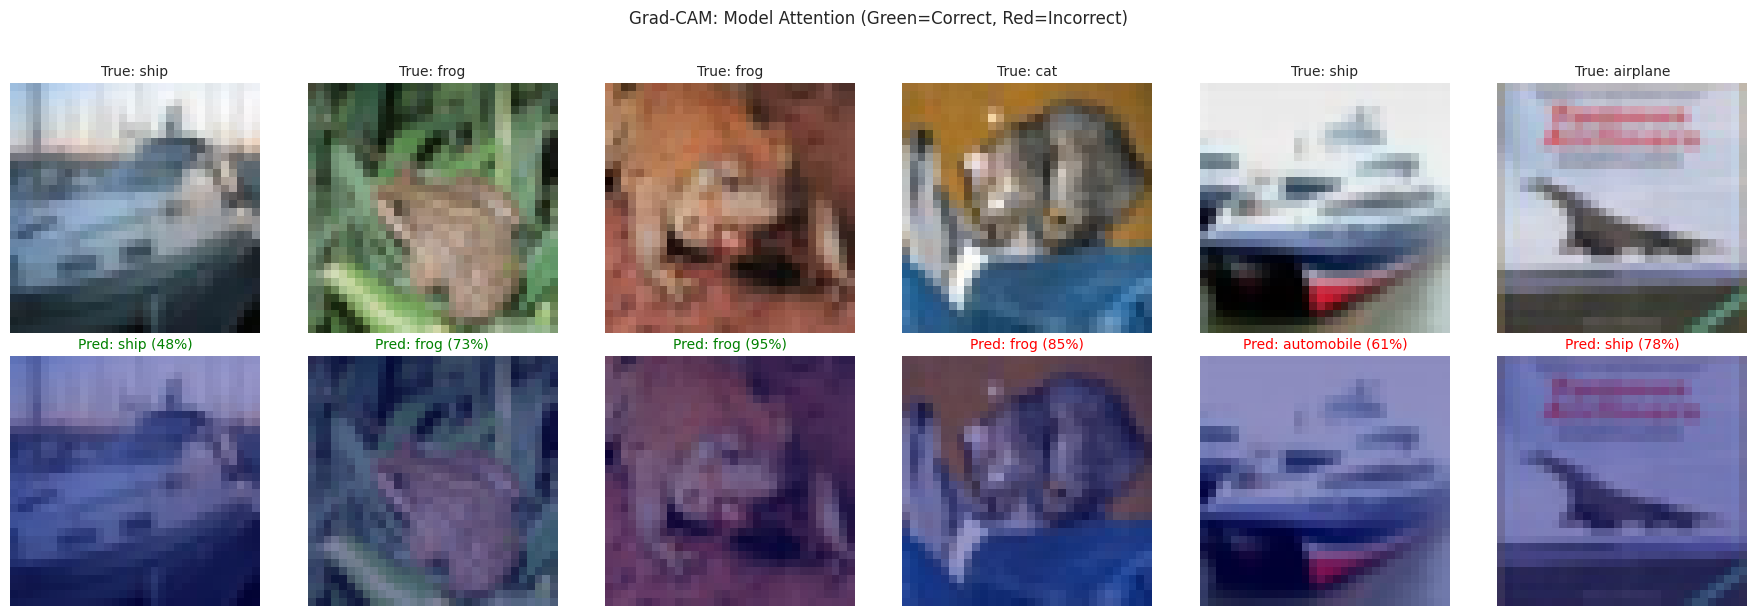

Saved: /home/berto/computer_vision/outputs/figures/gradcam_samples.png


In [27]:
# Cell 27
# Generate Grad-CAM visualizations for sample images
fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for i, idx in enumerate(sample_indices):
    img = x_test_norm[idx]
    img_batch = np.expand_dims(img, 0)
    
    # Generate heatmap
    heatmap, pred = make_gradcam_heatmap_v3(img_batch, model)
    
    # Resize heatmap to image size (7x7 -> 32x32)
    heatmap_resized = np.array(Image.fromarray(np.uint8(255 * heatmap)).resize((32, 32))) / 255.0
    
    # Row 0: Original image
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'True: {CLASS_NAMES[y_true[idx]]}', fontsize=10)
    axes[0, i].axis('off')
    
    # Row 1: Grad-CAM overlay
    heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]
    overlay = 0.6 * img + 0.4 * heatmap_colored
    overlay = np.clip(overlay, 0, 1)
    
    is_correct = y_pred[idx] == y_true[idx]
    title_color = 'green' if is_correct else 'red'
    conf = y_pred_probs[idx, y_pred[idx]]
    
    axes[1, i].imshow(overlay)
    axes[1, i].set_title(f'Pred: {CLASS_NAMES[y_pred[idx]]} ({conf:.0%})', 
                         fontsize=10, color=title_color)
    axes[1, i].axis('off')

# Add labels
axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Grad-CAM', fontsize=12)

plt.suptitle('Grad-CAM: Model Attention (Green=Correct, Red=Incorrect)', y=1.02)
plt.tight_layout()
plt.savefig(PATHS['figures'] / 'gradcam_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {PATHS['figures'] / 'gradcam_samples.png'}")


In [28]:
# Cell 28
# Grad-CAM analysis: Most confused class pairs
# From confusion matrix: cat<->dog, bird<->deer were most confused

# Find misclassified examples for these pairs
cat_as_dog = np.where((y_true == 3) & (y_pred == 5))[0][:2]  # cat predicted as dog
dog_as_cat = np.where((y_true == 5) & (y_pred == 3))[0][:2]  # dog predicted as cat
bird_as_deer = np.where((y_true == 2) & (y_pred == 4))[0][:2]  # bird predicted as deer

confused_pairs = [
    ('Cat→Dog', cat_as_dog),
    ('Dog→Cat', dog_as_cat),
    ('Bird→Deer', bird_as_deer)
]

print("Confusion analysis samples:")
for name, indices in confused_pairs:
    print(f"  {name}: {len(indices)} samples found")


Confusion analysis samples:
  Cat→Dog: 2 samples found
  Dog→Cat: 2 samples found
  Bird→Deer: 2 samples found


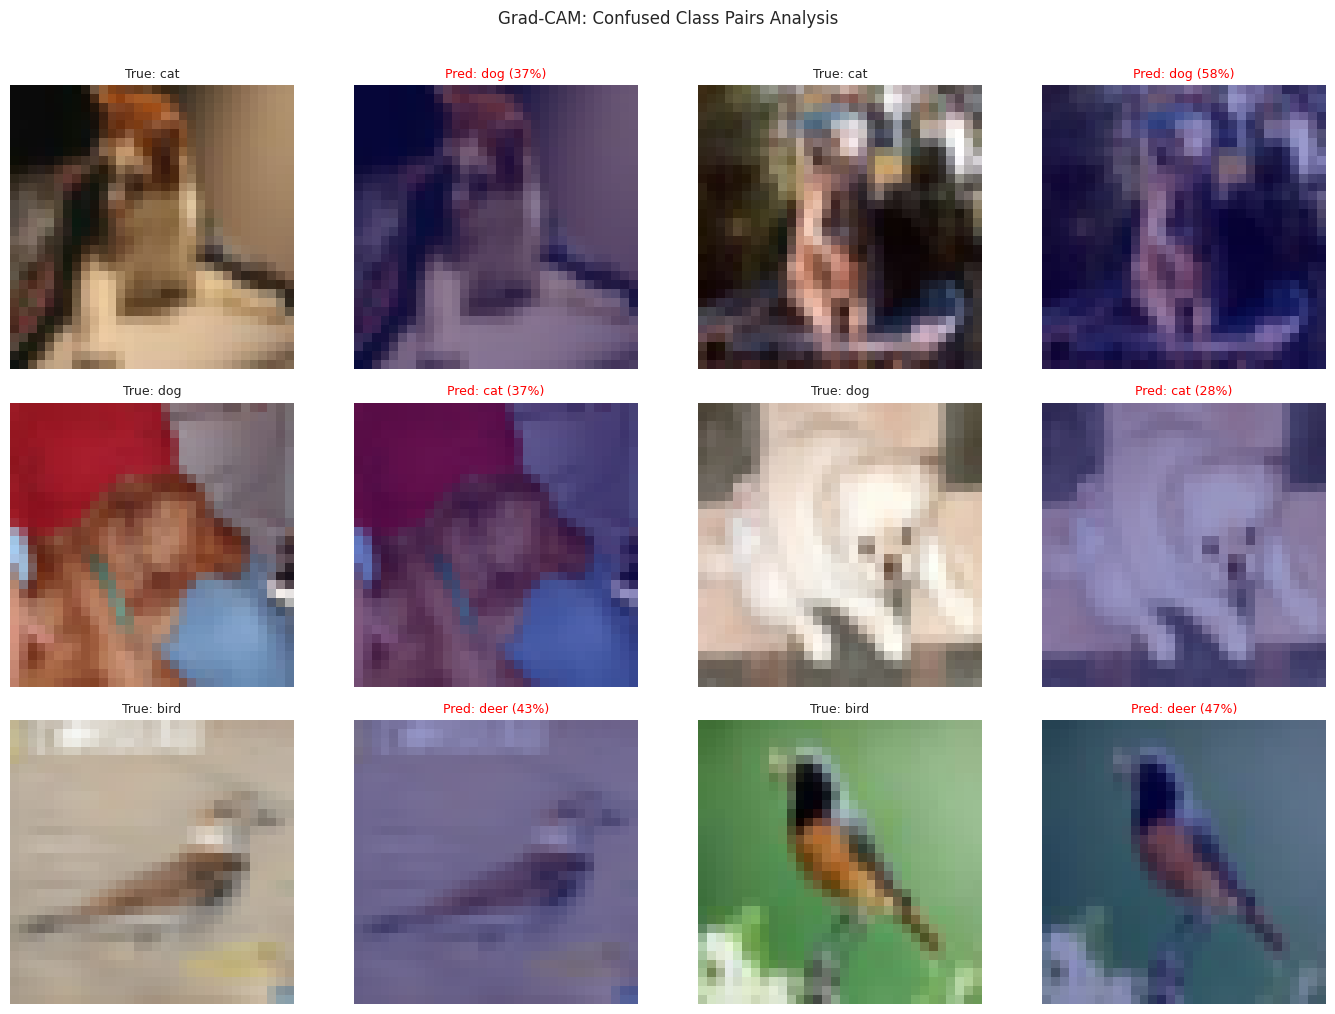

Saved: /home/berto/computer_vision/outputs/figures/gradcam_confusion_analysis.png


In [29]:
# Cell 29
# Grad-CAM for confused class pairs
fig, axes = plt.subplots(3, 4, figsize=(14, 10))

row = 0
for name, indices in confused_pairs:
    for col, idx in enumerate(indices):
        img = x_test_norm[idx]
        img_batch = np.expand_dims(img, 0)
        
        # Generate heatmap
        heatmap, _ = make_gradcam_heatmap_v3(img_batch, model)
        heatmap_resized = np.array(Image.fromarray(np.uint8(255 * heatmap)).resize((32, 32))) / 255.0
        
        # Original
        axes[row, col*2].imshow(img)
        axes[row, col*2].set_title(f'True: {CLASS_NAMES[y_true[idx]]}', fontsize=9)
        axes[row, col*2].axis('off')
        
        # Overlay
        heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]
        overlay = 0.6 * img + 0.4 * heatmap_colored
        overlay = np.clip(overlay, 0, 1)
        
        conf = y_pred_probs[idx, y_pred[idx]]
        axes[row, col*2+1].imshow(overlay)
        axes[row, col*2+1].set_title(f'Pred: {CLASS_NAMES[y_pred[idx]]} ({conf:.0%})', fontsize=9, color='red')
        axes[row, col*2+1].axis('off')
    
    # Row label
    axes[row, 0].set_ylabel(name, fontsize=11, rotation=0, labelpad=40, va='center')
    row += 1

plt.suptitle('Grad-CAM: Confused Class Pairs Analysis', y=1.01)
plt.tight_layout()
plt.savefig(PATHS['figures'] / 'gradcam_confusion_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {PATHS['figures'] / 'gradcam_confusion_analysis.png'}")


**GRAD-CAM ANALYSIS SUMMARY**

Key Observations:
1. Correct predictions: Model focuses on object body/shape
2. Cat↔Dog confusion: Similar body shapes, model focuses on fur texture
3. Bird↔Deer confusion: Both have similar silhouettes in natural settings

Model Attention Patterns:
- Vehicles (ship, truck, auto): Clear edges and distinct shapes
- Animals: Overlapping features cause confusion
- Small 32x32 images lose discriminative details after 224x224 upscaling

Limitations identified:
- Heatmap resolution (7x7) is coarse for 32x32 input
- Interpolation artifacts from resizing affect feature quality

## 10. Conclusions

### Project Summary

| Metric | Phase 1 (Frozen) | Phase 2 (Fine-tuned) | Target |
|--------|------------------|----------------------|--------|
| Val Accuracy | 10.5% | 49.0% | 65% |
| Test Accuracy | ~10% | 48.9% | 65% |
| Training Time | 25 min | 49 min | - |

### Key Findings

1. **Transfer learning requires input size compatibility**: ResNet50 pretrained on 224x224 images produced random-chance accuracy on native 32x32 CIFAR-10. Resizing was essential.

2. **Fine-tuning dramatically improves performance**: Unfreezing conv5 block improved accuracy from 10% to 49% (4.7x improvement).

3. **Architecture mismatch limits ceiling**: Upscaling 32x32→224x224 introduces interpolation artifacts. A smaller architecture (ResNet18, MobileNet) or CIFAR-specific model would be more appropriate.

4. **Class confusion follows visual similarity**: Cat/dog and bird/deer pairs were most confused due to similar shapes and textures.

### Recommendations for Future Work

- Use a model pretrained on smaller images or train from scratch
- Increase training data (full 50K CIFAR-10 training set)
- Try architectures designed for small images (e.g., ResNet-20 for CIFAR)
- Apply mixup or cutout augmentation for better generalization

**CIFAR-10 Classification Project – Final Summary**

---

**Results**

- **Test Accuracy:** 48.9%
- **Target:** 65%
- **Performance Gap:** 16.1 percentage points

---

**Training Time**

- **Phase 1 (Frozen Base):** ~28 minutes (3 min initial + 25 min retry)
- **Phase 2 (Fine-Tuning):** ~49 minutes  
- **Total Training Time:** ~77 minutes

---

**Model**

- **Architecture:** ResNet50 with custom classification head  
- **Input Resolution:** 32×32 → resized to 224×224  
- **Fine-Tuned Layers:** Conv5 block  
- **Total Parameters:** 24,114,826

---

**Saved Artifacts**

- **Raw Data:** 0 files  
- **Processed Data:** 0 files  
- **Models:** 6 files  
- **Figures:** 8 files

---

**Figures Generated**

- `augmentation_examples.png`
- `class_distribution.png`
- `confusion_matrix.png`
- `gradcam_confusion_analysis.png`
- `gradcam_samples.png`
- `phase1_training_curves.png`
- `phase2_training_curves.png`
- `sample_images.png`